ML Model with preprocessing script

--- Phase 1: Preprocessing & Feature Engineering ---


/tmp/ipython-input-1165553114.py:27: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/PS_2026.01.02_20.41.33.csv', comment='#')


Habitable Candidates Found: 90
Data preprocessed and saved to data/processed/exohabit_ml.csv

Training Samples: 4851 | Test Samples: 1213
Habitable Planets in Test Set: 18
Training set positives: 72

--- Starting Model Training & Evaluation ---

Training Baseline_LogReg...
Recall: 0.89 | F1 Score: 0.63 | AUC: 0.99

Training RandomForest...
Best Params for RandomForest: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 10}
Recall: 0.72 | F1 Score: 0.84 | AUC: 1.00

Training XGBoost...
Best Params for XGBoost: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1}
Recall: 0.72 | F1 Score: 0.84 | AUC: 1.00

>>> FINAL SELECTED MODEL: RandomForest <<<

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1195
           1       1.00      0.72      0.84        18

    accuracy                           1.00      1213
   macro avg       1.00      0.86      0.92      1213
weighted avg       1.00    

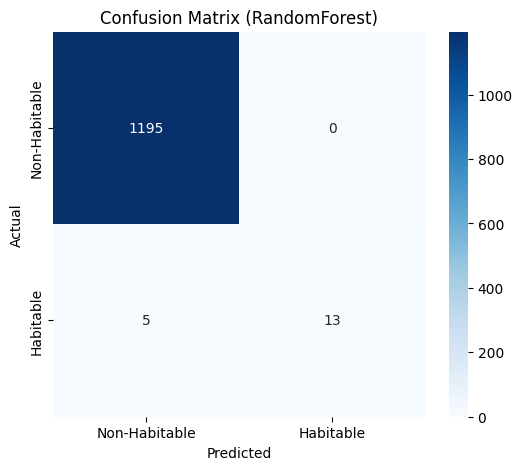

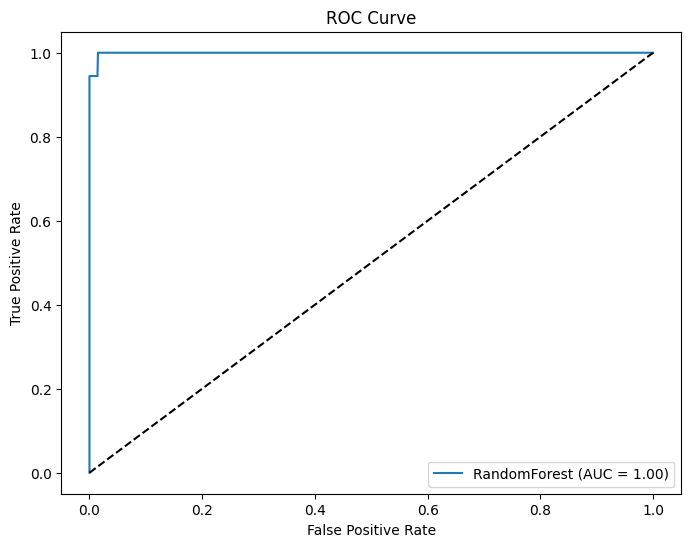

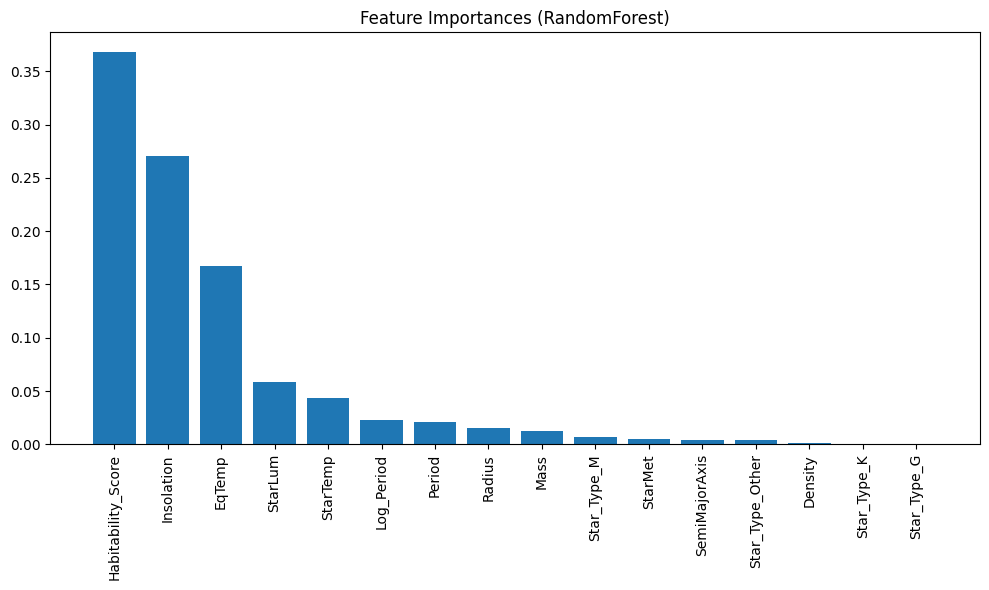


Model saved to models/randomforest.pkl
Ranked Habitability list saved to data/processed/habitability_ranked.csv

--- Top 5 Candidates by Probability ---
      Radius        Mass  EqTemp  Target_Habitable  Habitability_Probability
1395    2.43    5.460000   234.4                 1                  0.999853
297     2.43    5.890000   290.5                 1                  0.999853
562     2.43  950.306937   259.4                 1                  0.999803
5095    2.43    1.055000   218.0                 1                  0.999793
1889    2.25  174.487795   314.0                 1                  0.999793


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# ML Libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report, roc_curve)
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Create Directory Structure as per guidelines
os.makedirs('models', exist_ok=True)
os.makedirs('data/processed', exist_ok=True)

# ==========================================
# PHASE 1: REPRODUCE PREPROCESSING (Ensuring clean input)
# ==========================================
print("--- Phase 1: Preprocessing & Feature Engineering ---")
# Load Raw Data
df = pd.read_csv('/content/PS_2026.01.02_20.41.33.csv', comment='#')
df = df[df['default_flag'] == 1].copy()

# Feature Mapping
features_map = {
    'pl_rade': 'Radius', 'pl_bmasse': 'Mass', 'pl_orbper': 'Period',
    'pl_orbsmax': 'SemiMajorAxis', 'pl_eqt': 'EqTemp', 'pl_dens': 'Density',
    'st_teff': 'StarTemp', 'st_lum': 'StarLum', 'st_met': 'StarMet',
    'pl_insol': 'Insolation'
}
# Keep relevant columns + Star Type
df_clean = df[list(features_map.keys()) + ['st_spectype']].rename(columns=features_map).copy()

# Imputation
num_cols = list(features_map.values())
df_clean[num_cols] = SimpleImputer(strategy='median').fit_transform(df_clean[num_cols])

# Outlier Removal (Physics Sanity)
df_clean = df_clean[(df_clean['Radius'] > 0) & (df_clean['Radius'] < 50) & (df_clean['EqTemp'] > 0)]

# --- Target Engineering (Updated for broader detection) ---
# We relax the Radius to 2.5 (Hycean worlds) and Temp/Insolation ranges
is_rocky_or_water = df_clean['Radius'] <= 2.5  # Increased from 2.0
in_hz_insol = df_clean['Insolation'].between(0.2, 1.8) # Increased range
in_hz_temp = df_clean['EqTemp'].between(180, 330) # Increased range

# Combine logic
df_clean['Target_Habitable'] = (is_rocky_or_water & (in_hz_insol | in_hz_temp)).astype(int)

# Check counts immediately
print("Habitable Candidates Found:", df_clean['Target_Habitable'].sum())

# --- Feature Engineering ---
# Habitability Score (Proxy)
df_clean['Habitability_Score'] = (np.exp(-np.abs(df_clean['Radius'] - 1.0)) +
                                  np.exp(-np.abs((df_clean['EqTemp'] - 288)/288)) +
                                  np.exp(-np.abs(df_clean['Insolation'] - 1.0))) / 3.0
# Log Transform for skewed features
df_clean['Log_Period'] = np.log1p(df_clean['Period'])

# One-Hot Encoding for Star Type
df_clean['Star_Type'] = df_clean['st_spectype'].astype(str).str[0].str.upper().apply(lambda x: x if x in ['G','K','M','F'] else 'Other')
df_clean = pd.get_dummies(df_clean, columns=['Star_Type'], drop_first=True)
df_clean.drop(columns=['st_spectype'], inplace=True)

# Save processed file as per doc
df_clean.to_csv('data/processed/exohabit_ml.csv', index=False)
print("Data preprocessed and saved to data/processed/exohabit_ml.csv")

# ==========================================
# PHASE 2: ML MODEL TRAINING (Following Guidelines)
# ==========================================

# 1. Load & Split (Section 2)
data = pd.read_csv('data/processed/exohabit_ml.csv')
X = data.drop(columns=['Target_Habitable'])
y = data['Target_Habitable']

# Scaling
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split (80/20) with Stratification due to imbalance
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

print(f"\nTraining Samples: {len(X_train)} | Test Samples: {len(X_test)}")
print(f"Habitable Planets in Test Set: {sum(y_test)}")

# 2. Define Models (Sections 3 & 4)
# Define Models (Safe Weight Calculation)
num_positives = sum(y_train)
num_negatives = len(y_train) - num_positives

print(f"Training set positives: {num_positives}")

if num_positives > 0:
    pos_weight = num_negatives / num_positives
else:
    pos_weight = 1.0 # Default fallback to prevent crash
    print("WARNING: No habitable planets in training set! Model will not learn effectively.")

models = {
    'Baseline_LogReg': LogisticRegression(random_state=42, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, scale_pos_weight=pos_weight, eval_metric='logloss')
}

# 3. Hyperparameter Grids (Section 8)
param_grids = {
    'Baseline_LogReg': {}, # No tuning for baseline
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6, 10]
    }
}

# 4. Training & Evaluation Loop (Sections 6, 7, 9)
results = {}
best_model = None
best_f1 = 0

print("\n--- Starting Model Training & Evaluation ---")

for name, model in models.items():
    print(f"\nTraining {name}...")

    if name == 'Baseline_LogReg':
        clf = model
        clf.fit(X_train, y_train)
    else:
        # RandomizedSearchCV (Section 8)
        clf = RandomizedSearchCV(model, param_grids[name], n_iter=5, cv=3, scoring='f1', random_state=42, n_jobs=-1)
        clf.fit(X_train, y_train)
        print(f"Best Params for {name}: {clf.best_params_}")
        clf = clf.best_estimator_

    # Predictions
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    # Metrics (Section 7)
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results[name] = {'Accuracy': acc, 'Recall': rec, 'Precision': prec, 'F1': f1, 'AUC': auc, 'Model': clf}

    print(f"Recall: {rec:.2f} | F1 Score: {f1:.2f} | AUC: {auc:.2f}")

    # Check if this is the best model (Section 9 - Selection Criteria: Best F1 & Recall)
    if f1 > best_f1:
        best_f1 = f1
        best_model = name

# ==========================================
# PHASE 3: FINAL SELECTION & OUTPUTS
# ==========================================
print(f"\n>>> FINAL SELECTED MODEL: {best_model} <<<")
final_model = results[best_model]['Model']

# 1. Detailed Evaluation of Best Model (Section 7 - Mandatory Outputs)
y_final_pred = final_model.predict(X_test)
y_final_prob = final_model.predict_proba(X_test)[:, 1]

print("\n--- Classification Report ---")
print(classification_report(y_test, y_final_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_final_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Habitable', 'Habitable'], yticklabels=['Non-Habitable', 'Habitable'])
plt.title(f'Confusion Matrix ({best_model})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_final_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'{best_model} (AUC = {results[best_model]["AUC"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 2. Feature Importance (Section 11 - Interpretability)
if best_model in ['RandomForest', 'XGBoost']:
    importances = final_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances ({best_model})")
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
    plt.tight_layout()
    plt.show()

# 3. Saving Artifacts (Section 6 & 10)
# Save Model
model_path = f'models/{best_model.lower()}.pkl'
joblib.dump(final_model, model_path)
print(f"\nModel saved to {model_path}")

# Generate Ranked List (Section 10)
# Apply to full dataset
full_probs = final_model.predict_proba(X_scaled)[:, 1]
data['Habitability_Probability'] = full_probs
ranked_df = data[['Radius', 'Mass', 'EqTemp', 'Target_Habitable', 'Habitability_Probability']].sort_values(by='Habitability_Probability', ascending=False)

ranked_csv_path = 'data/processed/habitability_ranked.csv'
ranked_df.to_csv(ranked_csv_path, index=False)
print(f"Ranked Habitability list saved to {ranked_csv_path}")
print("\n--- Top 5 Candidates by Probability ---")
print(ranked_df.head(5))